In [190]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import urllib
import urllib.request
import zipfile
import random
from shutil import copyfile

In [ ]:
url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(url, "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = None)

inception_weight_file = os.getcwd()+'/Inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model.load_weights(inception_weight_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [ ]:
last_desired_layer = pre_trained_model.get_layer('mixed7')
last_desired_layer_output = last_desired_layer.output

print(last_desired_layer_output)

In [ ]:
x = tf.keras.layers.Flatten()(last_desired_layer_output)
x = tf.keras.layers.Dense(units = 1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(rate = 0.2)(x)
x = tf.keras.layers.Dense(units = 512, activation = 'relu')(x)
x = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(x)

model = tf.keras.models.Model(inputs = pre_trained_model.input, outputs = x)

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.002), metrics = ['accuracy'])

In [ ]:
model.summary()

In [115]:
class InceptionV3CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.98:
      print('\nReached maximum accuracy. Terminating Training process!!!!')
      self.model.stop_training = True

In [ ]:
base_path = os.getcwd()

In [70]:
dataset_path = base_path + '/tom_and_jerry'
os.listdir(dataset_path)

['training', 'validation']

In [69]:
train_dir = os.path.join(dataset_path, 'training')
validation_dir = os.path.join(dataset_path, 'validation')

os.makedirs(train_dir)
os.makedirs(validation_dir)

train_tom_dir =  os.path.join(train_dir, 'tom')
train_jerry_dir =  os.path.join(train_dir, 'jerry')

os.makedirs(train_tom_dir)
os.makedirs(train_jerry_dir)


validation_tom_dir =  os.path.join(validation_dir, 'tom')
validation_jerry_dir =  os.path.join(validation_dir, 'jerry')

os.makedirs(validation_tom_dir)
os.makedirs(validation_jerry_dir)  

In [71]:
for dataset_path, dirs, files in os.walk(dataset_path):
    for subdir in dirs:
        print(os.path.join(dataset_path, subdir))

C:\Users\User\OneDrive\Desktop\Notebooks/tom_and_jerry\training
C:\Users\User\OneDrive\Desktop\Notebooks/tom_and_jerry\validation
C:\Users\User\OneDrive\Desktop\Notebooks/tom_and_jerry\training\jerry
C:\Users\User\OneDrive\Desktop\Notebooks/tom_and_jerry\training\tom
C:\Users\User\OneDrive\Desktop\Notebooks/tom_and_jerry\validation\jerry
C:\Users\User\OneDrive\Desktop\Notebooks/tom_and_jerry\validation\tom


In [92]:
Data_Tom_Dir = os.getcwd() + '/tom_&_jerry/tom'
Data_Jerry_Dir = os.getcwd() + '/tom_&_jerry/jerry'
#os.listdir(Train_Tom_Dir)

In [105]:
SPLIT_SIZE = 0.9

total_file_number =  len(os.listdir(Data_Tom_Dir))
train_file_number = int(len(os.listdir(Data_Tom_Dir)) * SPLIT_SIZE)
validation_split = int(total_file_number - train_file_number)

TRAIN_TOM_FILES = random.sample(os.listdir(Data_Tom_Dir), train_file_number)
VALIDATION_TOM_FILES = [x for x in os.listdir(Data_Tom_Dir) if x not in TRAIN_FILES]

193

In [110]:
SPLIT_SIZE = 0.9

total_file_number =  len(os.listdir(Data_Jerry_Dir))
train_file_number = int(len(os.listdir(Data_Jerry_Dir)) * SPLIT_SIZE)
validation_split = int(total_file_number - train_file_number)

TRAIN_JERRY_FILES = random.sample(os.listdir(Data_Jerry_Dir), train_file_number)
VALIDATION_JERRY_FILES = [x for x in os.listdir(Data_Jerry_Dir) if x not in TRAIN_JERRY_FILES]

In [95]:
def train_validation_split(file_list, source_dir, destination_dir):
    for idx, f in enumerate(file_list):
        if os.path.getsize(os.path.join(source_dir, f)) != 0:
            source = os.path.join(source_dir, f)
            destination = os.path.join(destination_dir, f)
            copyfile(source, destination)
        else:
            print(f'{f} is zero length, so ignoring.')

In [111]:
train_split = train_validation_split(TRAIN_TOM_FILES, Data_Tom_Dir, train_tom_dir)
validation_split = train_validation_split(VALIDATION_TOM_FILES, Data_Tom_Dir, validation_tom_dir)

In [112]:
train_split = train_validation_split(TRAIN_JERRY_FILES, Data_Jerry_Dir, train_jerry_dir)
validation_split = train_validation_split(VALIDATION_JERRY_FILES, Data_Jerry_Dir, validation_jerry_dir)

In [114]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

 
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

 
validation_datagen = ImageDataGenerator(rescale = 1.0 / 255.)


validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                target_size=(150, 150))


Found 2853 images belonging to 2 classes.
Found 317 images belonging to 2 classes.


In [118]:
callback = InceptionV3CallBack()
history = model.fit(train_generator, epochs = 1, validation_data = validation_generator, callbacks = [callback])

90/90 [==============================] - 77s 850ms/step - loss: 0.1840 - accuracy: 0.9432 - val_loss: 0.1098 - val_accuracy: 0.9811


In [ ]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(2000, 1000), dpi=1000)
plt.figure()

plt.show()

In [120]:
class_map = train_generator.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [124]:
classes

['jerry', 'tom']

In [145]:
from tensorflow.keras.preprocessing import image

def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = int(model.predict(img_processed)[0][0])

    
    #index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[prediction]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 55ms/step


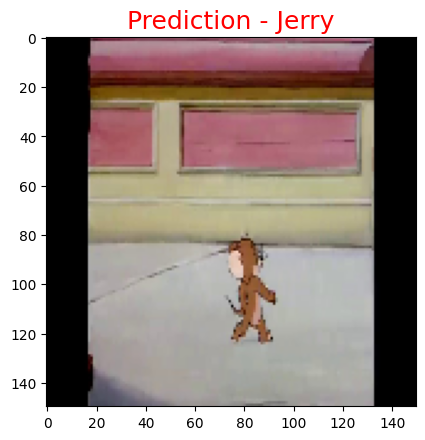

In [147]:
image_path = base_path + '/tom_&_jerry/jerry/frame1937.jpg'
predict_image(image_path , model)

In [162]:
label_dict = {}
data_dir = os.listdir(base_path + '/tom_and_jerry/training') 
for i in range(len(data_dir)):
    label_dict[i] = data_dir[i]

In [163]:
label_dict

{0: 'jerry', 1: 'tom'}

In [226]:
Test_Data_Dir = os.getcwd() + '/tom_&_jerry/test'
image_list =  os.listdir(Test_Data_Dir)
test_array = np.zeros((len(image_list), 150, 150, 3))

for i in range(len(image_list)):
    test_image = Image.open(os.path.join(Test_Data_Dir, image_list[i]))
    test_image = test_image.resize((150, 150))
    test_image_array = np.copy(test_image) / 255.
    test_array[i] = test_image_array

In [229]:
prediction = model.predict(test_array)

for i in range(len(prediction)):
    if prediction[i] > 0.5:
        prediction[i] = 1
    else:
        prediction[i] = 0

1/1 [==============================] - 0s 156ms/step


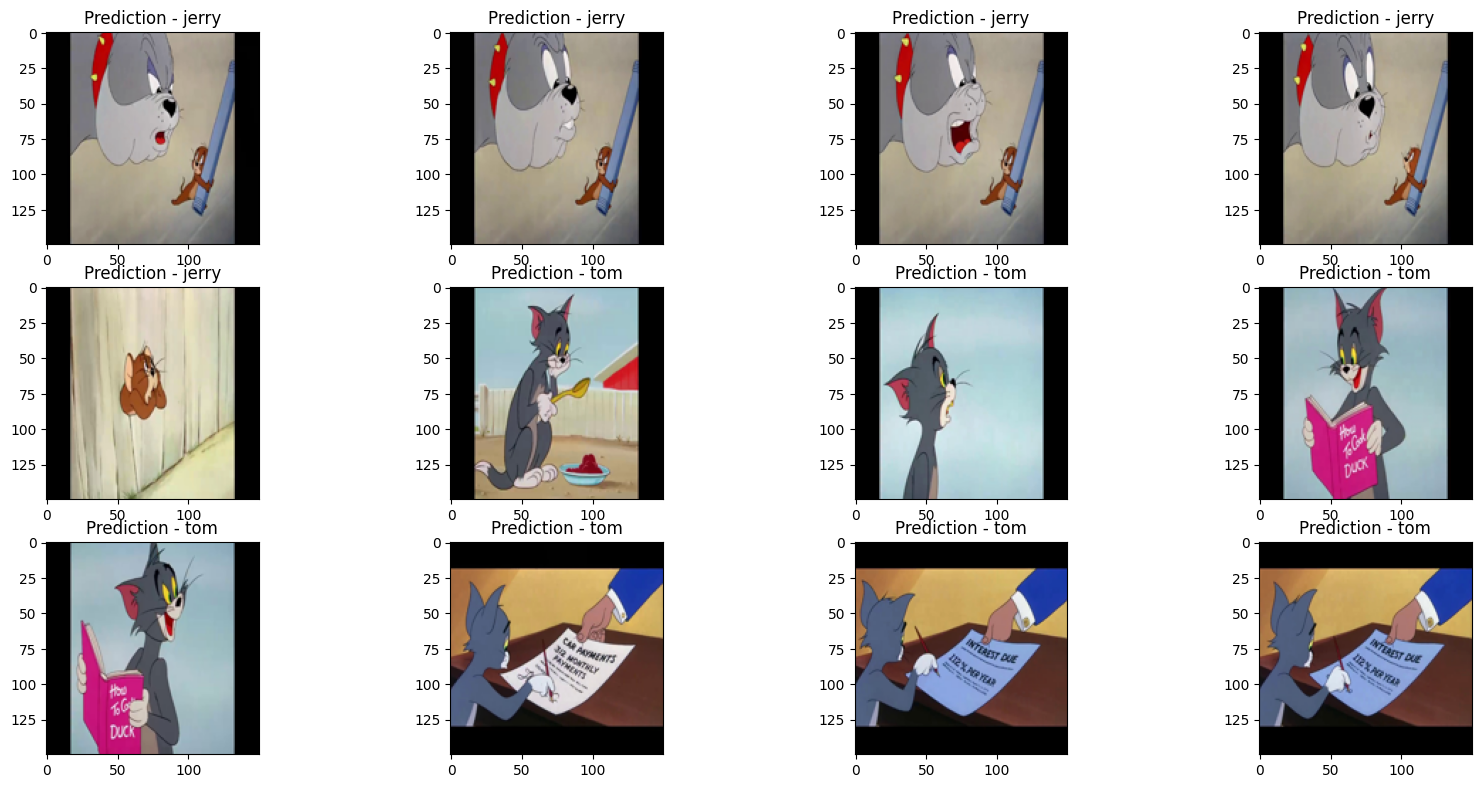

In [228]:
fig = plt.figure(figsize=(20, 16))
columns = 4
rows = 5

for k in range(12):
    
    img = test_array[k]
    img = array_to_img(img)
    pred = int(prediction[k][0])
    fig.add_subplot(rows, columns, k+1)
    plt.title("Prediction - {}".format(label_dict[pred]))
    plt.imshow(img)
    
plt.show()

In [235]:
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
model_path = os.path.join(os.getcwd(), 'Tom_Jerry_Model')

with open(model_path + "Inception_Tom_Jerry_Model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights(model_path + "Inception_Tom_Jerry_Model_Weights.h5")

In [237]:
json_file = open(model_path + 'Inception_Tom_Jerry_Model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights(model_path + "Inception_Tom_Jerry_Model_Weights.h5")